In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite

### Component info

In [2]:
comp_info = np.loadtxt('../data/recipes/comp_info.tsv', dtype=str, delimiter='\t')

In [3]:
comp_info

array([['0', 'jasmone', '488-10-8'],
       ['1', '5-methylhexanoic_acid', '628-46-6'],
       ['2', 'l-glutamine', '56-85-9'],
       ...,
       ['1104', 'guaiacol', '90-05-1'],
       ['1105', '(+/?)-methyl_5-acetoxyhexanoate', '35234-22-1'],
       ['1106', 'ethyl_sorbate', '2396-84-1']], dtype='<U93')

In [4]:
id_comp_dict = dict()
for line in comp_info:
    id_comp_dict[int(line[0])] = line[1]
comp_id_dict = {v:k for k, v in id_comp_dict.items()}

### Ingredient info

In [5]:
ingr_info = np.loadtxt('../data/recipes/ingr_info.tsv', dtype=str, delimiter='\t')

In [6]:
ingr_info

array([['0', 'magnolia_tripetala', 'flower'],
       ['1', 'calyptranthes_parriculata', 'plant'],
       ['2', 'chamaecyparis_pisifera_oil', 'plant derivative'],
       ...,
       ['1527', 'green_tea', 'plant derivative'],
       ['1528', 'artemisia_porrecta_oil', 'plant derivative'],
       ['1529', 'munster_cheese', 'dairy']], dtype='<U35')

In [7]:
id_ingr_dict = dict()
for line in ingr_info:
    id_ingr_dict[int(line[0])] = line[1]
ingr_id_dict = {v:k for k, v in id_ingr_dict.items()}

### Recipes and regions

In [8]:
recipes_dict = dict()
regions_dict = dict()

In [9]:
with open('../data/recipes/menu_recipes.txt') as f:
    for i, line in enumerate(f):
        alist = line.rstrip('\n').split()
        region = alist[0]
        ingr = alist[1:]
        regions_dict[i] = region
        recipes_dict[i] = ingr

In [10]:
id_region_dict = dict()
region_id_dict = dict()
for i, region in enumerate(set(regions_dict.values())):
    id_region_dict[i] = region
    region_id_dict[region] = i

### Region/recipe biadjacency matrix

In [11]:
bmat_region_recipe = np.zeros((len(id_region_dict), len(recipes_dict)))
for recipe, region in regions_dict.items():
    j = recipe
    i = region_id_dict[region]
    bmat_region_recipe[i, j] = 1

In [12]:
bmat_region_recipe.shape

(8, 2458)

### Recipe/ingredient biadjacency matrix

In [13]:
bmat_recipe_ingr = np.zeros((len(recipes_dict), len(id_ingr_dict)))
for recipe, ingreds in recipes_dict.items():
    i = recipe
    jlist = [ingr_id_dict[x] for x in ingreds]
    bmat_recipe_ingr[i, jlist] = 1

In [14]:
print([id_ingr_dict[x] for x in np.argwhere(bmat_recipe_ingr[0]).flatten()])
print(recipes_dict[0])

['sesame_oil', 'garlic', 'lettuce', 'beef', 'sake', 'beef_broth', 'scallion', 'oyster', 'vegetable_oil', 'soy_sauce', 'starch', 'onion']
['onion', 'beef', 'starch', 'sake', 'soy_sauce', 'scallion', 'lettuce', 'garlic', 'vegetable_oil', 'beef_broth', 'oyster', 'sesame_oil']


In [15]:
bmat_recipe_ingr.shape

(2458, 1530)

### Ingredient/compound biadjacency matrix

In [16]:
ingr_comp = np.loadtxt('../data/recipes/ingr_comp.tsv', dtype=int, delimiter='\t')

In [17]:
ingr_comp

array([[1392,  906],
       [1259,  861],
       [1079,  673],
       ...,
       [ 689,  650],
       [ 689,  297],
       [1080,   13]])

In [18]:
bmat_ingr_comp = np.zeros((len(id_ingr_dict), len(id_comp_dict)))
for item in ingr_comp:
    i, j = item
    bmat_ingr_comp[i, j] = 1

In [19]:
print(bmat_ingr_comp[1392, 906])
print(bmat_ingr_comp[1392, 907])

1.0
0.0


In [20]:
bmat_ingr_comp.shape

(1530, 1107)

### Setup for link prediction

In [21]:
import os
import sys
linkpred_path = os.path.abspath(os.path.join('../linkpred/'))
if linkpred_path not in sys.path:
    sys.path.append(linkpred_path)

import b_lcp, b_mi, b_probas, b_si, b_util, b_val

In [22]:
fraction = 0.1
loops = 100 #1
verbose=True
plot=True

In [23]:
# Precompute links to delete for all datasets
links_to_del_region_recipe = b_val.get_links_to_del(bmat_region_recipe, fraction=fraction, loops=loops)
links_to_del_recipe_ingr = b_val.get_links_to_del(bmat_recipe_ingr, fraction=fraction, loops=loops)
links_to_del_ingr_comp = b_val.get_links_to_del(bmat_ingr_comp, fraction=fraction, loops=loops)

# Jorge's approach:
## to calculate ALL the scores for a given dataset and deleted links, then call it in the next functions

In [24]:
def delete_links(x, links_to_del):
    """Deletes the specified links from an adjacency matrix."""
    x_ = np.copy(x)
    for link in links_to_del:
        x_[link[0], link[1]] = 0
        
    return x_

In [ ]:
bmat_recipe_ingr.shape

In [ ]:
links_to_del_recipe_ingr.shape

In [ ]:
scores_list = []
for i in range(loops):    
    x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
    missing = np.argwhere(x_ == 0)
    ## SAVE ALL THE SCORES:
    lcp_scores = b_lcp.bipartite_lcp_all(x_, missing, verbose=verbose)
    scores_list.append(lcp_scores)
scores_array = np.array(scores_list)

In [ ]:
scores_array.shape

In [ ]:
assert links_to_del_recipe_ingr.shape[0] == loops

In [ ]:
metrics_list = ['lcl', 'cn', 'jc', 'car', 'cjc', 'cpa', 'ra', 'aa', 'cra', 'caa', 'cpi']

def cross_val(scores, metric, loops=10, raw_output=False, verbose=True, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))

    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i + 1, loops))
        x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
        missing = np.argwhere(x_ == 0)
        true = bmat_recipe_ingr[missing[:,0], missing[:,1]]
        
        score = scores_array[i, metrics_list.index(metric)]
        
        if raw_output:
            scores_list.append(score)
            true_list.append(true)
        else:
            results[i] = b_val.evaluate_predictions(true, score, plot=plot)
        
    if raw_output:
        return true_list, scores_list
    else:
        return results

In [ ]:
r_cn = cross_val(lcp_scores, 'cn', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r_cn, axis=0))
print(np.std(r_cn, axis=0))

In [ ]:
r_cn

In [ ]:
r_lcl = cross_val(lcp_scores, 'lcl', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r_lcl, axis=0))
print(np.std(r_lcl, axis=0))

In [ ]:
r_lcl

### Recipe-Ingredient

In [ ]:
# CN
r01 = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r01, axis=0))
print(np.std(r01, axis=0))

In [ ]:
# LCL
r02 = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('lcl',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r02, axis=0))
print(np.std(r02, axis=0))

# IT WORKS!
## Now I have to parallelize the trials

In [25]:
import time

In [26]:
import dask

In [27]:
from dask import delayed  # DON'T CHANGE (explained later)

def func(i):
    print(f'Trial {i} starting...')
    scores_list = []
    x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
    missing = np.argwhere(x_ == 0)
    lcp_scores = b_lcp.bipartite_lcp_all(x_, missing, verbose=verbose)
    scores_list.append(lcp_scores)
    print(f'... Trial {i} done')
    return scores_list

#loops = 2
lazy = [delayed(func)(i) for i in range(loops)]  # DON'T CHANGE (explained later)

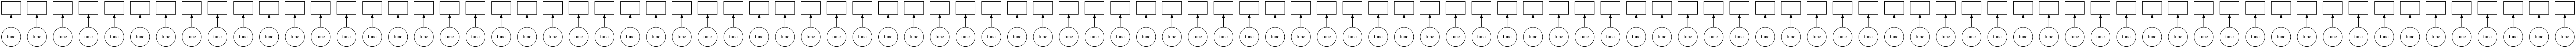

In [28]:
dask.visualize(lazy)

In [ ]:
"""%%time
start = time.time()
scheduler = 'single-threaded'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")"""

In [ ]:
"""%%time
start = time.time()
scheduler = 'threads'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")"""

In [29]:
%%time
start = time.time()
scheduler = 'processes'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")

Trial 2 starting...
Trial 60 starting...
Trial 76 starting...
Trial 67 starting...
Trial 0 starting...
Trial 73 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 77 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Trial 31 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarnin

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning

100.00 %, 12.15 minutes
... Trial 2 done
100.00 %, 12.17 minutes
... Trial 67 done
100.00 %, 12.19 minutes
... Trial 73 done
Trial 46 starting...
100.00 %, 12.24 minutes
... Trial 60 done
Computing bipartite LCP
Trial 27 starting...
Computing bipartite LCP
Trial 36 starting...
100.00 %, 12.30 minutes
... Trial 77 done
Computing bipartite LCP
Trial 49 starting...
100.00 %, 12.33 minutes
... Trial 0 done
100.00 %, 12.35 minutes
... Trial 76 done
Computing bipartite LCP
100.00 %, 12.37 minutes
... Trial 31 done
Trial 58 starting...
Computing bipartite LCP
Trial 63 starting...
Trial 20 starting...
Computing bipartite LCP
Trial 8 starting...
Computing bipartite LCP
Computing bipartite LCP
100.00 %, 12.05 minutes
... Trial 46 done
Trial 40 starting...
100.00 %, 12.09 minutes
... Trial 36 done
Computing bipartite LCP
Trial 69 starting...
Computing bipartite LCP
100.00 %, 12.32 minutes
... Trial 27 done
100.00 %, 12.16 minutes
... Trial 8 done
100.00 %, 12.18 minutes
... Trial 20 done
100.00 %

MemoryError: 

100.00 %, 11.50 minutes
... Trial 96 done
100.00 %, 11.17 minutes
... Trial 54 done
100.00 %, 11.52 minutes
... Trial 82 done
100.00 %, 10.93 minutes
... Trial 70 done
100.00 %, 10.95 minutes
... Trial 90 done
100.00 %, 10.11 minutes
... Trial 18 done


In [30]:
res[0][1]

NameError: name 'res' is not defined

In [ ]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

### Ingredient-Compound

In [ ]:
# CN
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# LCL
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('lcl',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))